In [1]:
import nltk
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
pwd

'/Users/shagunjindal'

In [3]:
df = pd.read_csv('train.csv', encoding='latin-1')

In [4]:
#dropping NaN and "dont care" response to setup a binary analysis.
df = df[df['sentiment']!="3"]
df = df[df['sentiment']!='not_relevant']
df = df.reset_index()

#dropping the extra columns
df = df.drop(['index', '_unit_id', '_golden', '_unit_state', '_trusted_judgments', '_last_judgment_at', 'date','id','query', 'sentiment_gold'], axis =1)

def encoder(x):
    #A simple class encoder to get to 1s and 0s for each of the sentiment
    if x=='5':
        return 1
    else:
        return 0

#Apply encoder to sentiment column
df['sentiment'] = df['sentiment'].apply(encoder)

df.head()

,sentiment,sentiment:confidence,text
0,1,0.8468,Top 3 all @Apple #tablets. Damn right! http://...
1,1,0.6736,CNBCTV: #Apple's margins better than expected?...
2,0,1.0000,WTF MY BATTERY WAS 31% ONE SECOND AGO AND NOW ...
3,1,1.0000,RT @peterpham: Bought my @AugustSmartLock at t...
4,0,1.0000,@apple Contact sync between Yosemite and iOS8 ...


In [5]:
print('\n\nSentiment Values: ')
print(df.sentiment.value_counts())



Sentiment Values: 
0    1219
1     423
Name: sentiment, dtype: int64


In [6]:
from sklearn.model_selection import train_test_split

def standardize_text(df, text_field):
    #removes special strings and non text
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

df = standardize_text(df, 'text')
df.to_csv('clean_apple.csv')
df.head()

,sentiment,sentiment:confidence,text
0,1,0.8468,top 3 all tablets damn right!
1,1,0.6736,cnbctv apple's margins better than expected?...
2,0,1.0000,wtf my battery was 31 one second ago and now ...
3,1,1.0000,rt bought my at the store pretty good logo...
4,0,1.0000,contact sync between yosemite and ios8 is ser...


In [7]:
from nltk.tokenize import RegexpTokenizer

#NLTK tokenizer
tokenizer = RegexpTokenizer(r'\w+')
df['tokens'] = df['text'].apply(tokenizer.tokenize)
df.head()

,sentiment,sentiment:confidence,text,tokens
0,1,0.8468,top 3 all tablets damn right!,"[top, 3, all, tablets, damn, right]"
1,1,0.6736,cnbctv apple's margins better than expected?...,"[cnbctv, apple, s, margins, better, than, expe..."
2,0,1.0000,wtf my battery was 31 one second ago and now ...,"[wtf, my, battery, was, 31, one, second, ago, ..."
3,1,1.0000,rt bought my at the store pretty good logo...,"[rt, bought, my, at, the, store, pretty, good,..."
4,0,1.0000,contact sync between yosemite and ios8 is ser...,"[contact, sync, between, yosemite, and, ios8, ..."


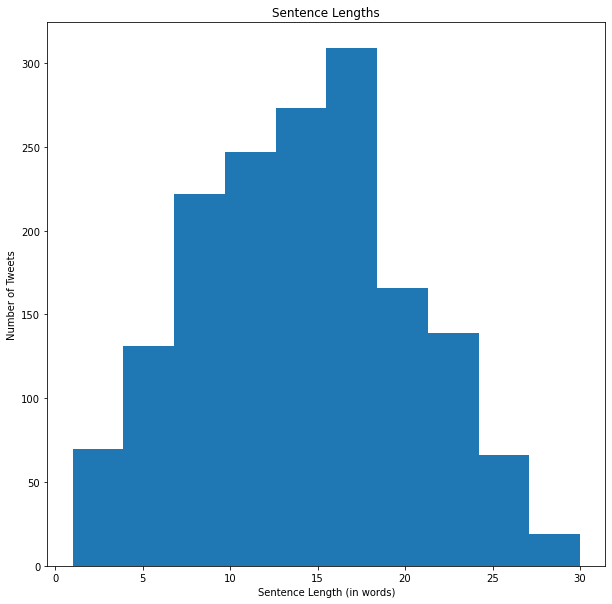

In [8]:
sentence_lengths = [len(tokens) for tokens in df['tokens']]
vocab = sorted(list(set([word for tokens in df['tokens'] for word in tokens])))

plt.figure(figsize = (10,10))
plt.xlabel('Sentence Length (in words)')
plt.ylabel('Number of Tweets')
plt.title('Sentence Lengths')
plt.hist(sentence_lengths)
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X = df[['text', 'sentiment:confidence']]
y = df['sentiment']

#splitting data for cross validation of model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,shuffle=False)

#Keeping the assignment confidence for later
X_train_conf, X_test_conf = X_train['sentiment:confidence'], X_test['sentiment:confidence']
X_train, X_test = X_train['text'], X_test['text']

#saving to csv
X_train.to_csv('train_clean.csv')
X_test.to_csv('test_clean.csv')
y_train.to_csv('y_train.csv')
y_test.to_csv('y_test.csv')

print(X_train[:5])

0                    top 3 all   tablets  damn right! 
1    cnbctv   apple's margins better than expected?...
2    wtf my battery was 31  one second ago and now ...
3    rt  bought my  at the  store  pretty good logo...
4     contact sync between yosemite and ios8 is ser...
Name: text, dtype: object


In [10]:
#vectorization with TFIDF and scikit learn
vect = TfidfVectorizer()
X_train_tfidf = vect.fit_transform(X_train)
X_test_tfidf = vect.transform(X_test)


#sparse matrix rows << columns
X_train_tfidf[0]

<1x3245 sparse matrix of type '<class 'numpy.float64'>'
	with 5 stored elements in Compressed Sparse Row format>

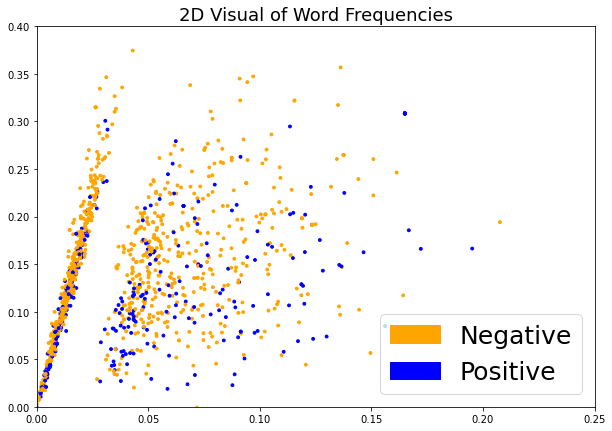

In [11]:
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches

def plot_lsa(text, labels, plot=True):
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(text)
    lsa_scores = lsa.transform(text)
    color_dict = {label:idx for idx, label in enumerate(set(labels))}
    color_column = [color_dict[label] for label in labels]
    colors = ['orange', 'blue']
    if plot:
        plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, c = labels, cmap = matplotlib.colors.ListedColormap(colors))
        red_patch = mpatches.Patch(color='orange', label='Negative')
        green_patch = mpatches.Patch(color='blue', label='Positive')
        plt.legend(handles=[red_patch, green_patch], prop={'size': 25})

fig = plt.figure(figsize =(10,7))
plot_lsa(X_train_tfidf, y_train)
plt.xlim(0,0.25)
plt.ylim(0,0.4)
plt.title("2D Visual of Word Frequencies", size = 18)
plt.show()

In [12]:
from sklearn.linear_model import LogisticRegressionCV

logr = LogisticRegressionCV()
logr.fit(X_train_tfidf, y_train)
y_pred_logr = logr.predict(X_test_tfidf)

In [13]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline



clf = SVC(class_weight = 'balanced')
pipe = Pipeline([('classifier', clf)])
fit_params = {'classifier__kernel':['rbf', 'linear', 'poly'],
          'classifier__degree':[2, 3, 4],
          'classifier__C':[0.01, 0.1, 1, 10]}

gs = GridSearchCV(pipe, fit_params, cv = 10, return_train_score = True)
gs.fit(X_train_tfidf, y_train)


print('Best performing classifier parameters (score {}):\n{}'.format(gs.best_score_, gs.best_params_))

pipe.set_params(classifier__degree = gs.best_params_['classifier__degree'],
                classifier__kernel = gs.best_params_['classifier__kernel'],
               classifier__C = gs.best_params_['classifier__C'])
pipe.fit(X_train_tfidf, y_train)
y_pred = pipe.predict(X_test_tfidf)

Best performing classifier parameters (score 0.8416377515614158):
{'classifier__C': 10, 'classifier__degree': 2, 'classifier__kernel': 'linear'}


In [14]:
from sklearn.metrics import accuracy_score, classification_report

#Logistic Regression Eval
print('Logistic Regression Accuracy: ', accuracy_score(y_test, y_pred_logr))
print('\nLogistic Classification Report: \n' , classification_report(y_test,  y_pred_logr))

#SVM Eval
print('\n\n SVM Accuracy: ', accuracy_score(y_test, y_pred))
print('\nSVM Classification Report: \n' , classification_report(y_test,  y_pred))

Logistic Regression Accuracy:  0.7203647416413373

Logistic Classification Report: 
               precision    recall  f1-score   support

           0       0.75      0.90      0.82       226
           1       0.60      0.33      0.42       103

    accuracy                           0.72       329
   macro avg       0.67      0.61      0.62       329
weighted avg       0.70      0.72      0.69       329



 SVM Accuracy:  0.7264437689969605

SVM Classification Report: 
               precision    recall  f1-score   support

           0       0.76      0.88      0.82       226
           1       0.60      0.38      0.46       103

    accuracy                           0.73       329
   macro avg       0.68      0.63      0.64       329
weighted avg       0.71      0.73      0.71       329



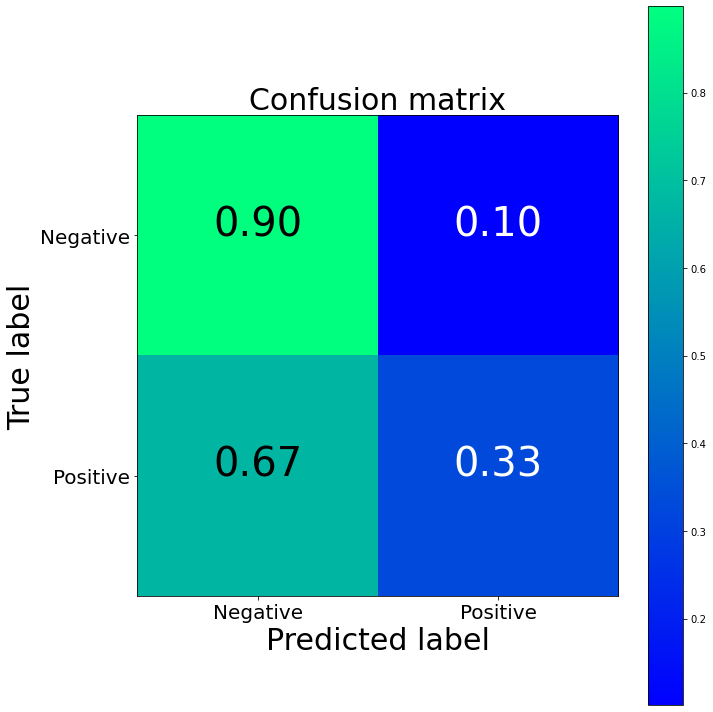

[[203  23]
 [ 69  34]]


In [15]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)
    return plt

cm = confusion_matrix(y_test, y_pred_logr)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Negative','Positive'], normalize=True, title='Confusion matrix')
plt.show()
print(cm)

In [16]:
def find_fn(ypred, ytrue):
    y_fn  = X_test[(ypred==0)&(ypred!=ytrue)]
    return y_fn

fn = find_fn(y_pred_logr, y_test)
print('Number of False Negatives: ', fn.shape, '\n')
print(fn[:1].values, '\n')
print(fn[1:2].values, '\n')
print(fn[2:3].values, '\n')
print(fn[3:4].values)

Number of False Negatives:  (69,) 

['apple continues beefing up digital audio expertise by hiring dana massie from audience  aapl  aapl \n'] 

['it makes you smarter   elevate is  app of the year!  congratulations  and team   '] 

['rt  it makes you smarter   elevate is  app of the year!  congratulations  and team   '] 

['rt  it makes you smarter   elevate is  app of the year!  congratulations  and team   ']


In [17]:
def find_fp(ypred, ytrue):
    y_fp  = X_test[(ypred==1)&(ypred!=ytrue)]
    return y_fp

fp = find_fp(y_pred_logr, y_test)
print('Number of False Positives: ', fp.shape, '\n')
print(fp[:1].values, '\n')
print(fp[1:2].values, '\n')
print(fp[2:3].values, '\n')
print(fp[3:4].values)

Number of False Positives:  (23,) 

['dear   amp   i understand you want to protect me  is there any way you can cool it on password lockouts  amp  resets?'] 

["rt  higher price targets are not helping apple's shares  aapl  aapl \n"] 

['   \nbeware of anything that includes the word care '] 

['thank you  for being such a little troll but putting the option close right above the save tab  legends']


In [18]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}

    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(vect, logr, 10)

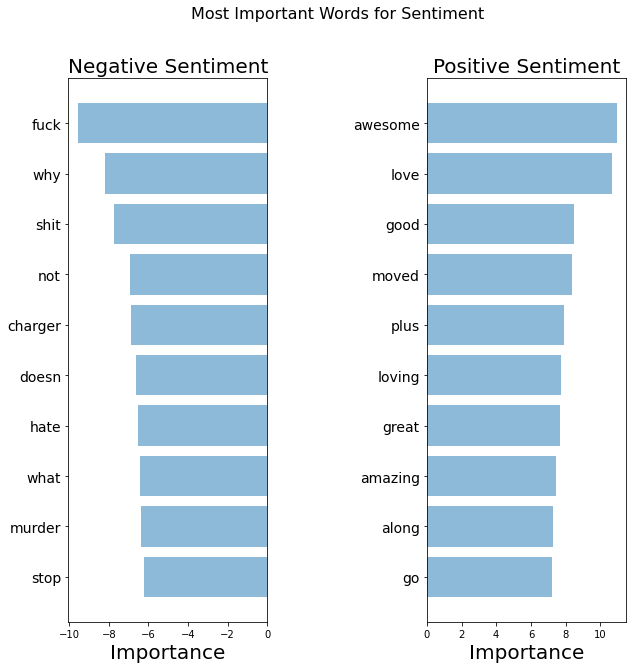

In [19]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])

    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)

    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]

    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]

    fig = plt.figure(figsize=(10, 10))

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Negative Sentiment', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)

    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Positive Sentiment', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)

    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most Important Words for Sentiment")